# 데이터 불러오기

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


feature engineering을 마치고 사이즈를 줄인 데이터를 불러오기

In [ ]:
import pandas as pd

df = pd.read_csv('/content/drive/MyDrive/AIB/cp1/data_downsize.csv')

df.head()

user_id  product_id  up_order_num  up_reorder  up_avg_basketposition  \
0    57863        6317             1         0.0                   12.0   
1    82895        2893             1         0.0                    3.0   
2    86109       17375             1         0.0                    3.0   
3   112026       33845             2         0.5                   15.0   
4   160245       28204             1         0.0                    9.0   

   u_order_num  u_avg_basket  u_most_dow  u_most_hod  u_reorder  u_avg_gap  \
0           32      7.875000           0          16   0.484127   9.753968   
1           83      6.024096           1          12   0.428000   2.662000   
2           99      6.414141           0           9   0.803150   2.885039   
3           49     11.938776           1          15   0.733333   7.449573   
4           39     16.846154           1          13   0.712329   9.220700   

   u_product_num  p_order_num  p_reorder  p_avg_basketpositon  reordered  
0            252         1996   0.552605            10.326152        0.0  
1            500          129   0.364341             9.829457        0.0  
2            635          670   0.119403            10.322388        0.0  
3            585         4955   0.715237             8.171746        1.0  
4            657        89632   0.711922             7.013399        0.0

In [ ]:
df.shape

(84747, 16)

타겟값을 확인하였을 때 불균형 데이터이므로 모델의 성능 저하 우려가 있음  
따라서 타겟값을 비율을 맞춰주며 언더샘플링을 할 필요성이 있다고 판단

In [ ]:
X = df.drop(columns = 'reordered')
y = df['reordered']

y.value_counts(normalize = True)

0.0    0.902203
1.0    0.097797
Name: reordered, dtype: float64

언더샘플링의 방법 중 하나인 NearMiss 알고리즘으로 타겟 클래스 비율을 같게 만들어 줌

In [ ]:
import imblearn

In [ ]:
from imblearn.under_sampling import NearMiss 

nm = NearMiss()
X_res, y_res = nm.fit_resample(X, y)

그 결과 비율이 동일한 것을 확인할 수 있다

In [ ]:
y_res.value_counts(normalize = True)

0.0    0.5
1.0    0.5
Name: reordered, dtype: float64

트레인/테스트 셋으로 분리 

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size = 0.2, random_state = 42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((13260, 15), (3316, 15), (13260,), (3316,))

# 모델 적용 및 튜닝

**3가지 모델(Decision Tree, RandomForest, XGBoost)**

- 평가 지표 : f1 스코어



In [ ]:
# 하이퍼파라미터 튜닝 : max_depth, min_samples_leaf, max_features

from sklearn.tree import DecisionTreeClassifier
from scipy.stats import randint
from sklearn.model_selection import RandomizedSearchCV

dt = DecisionTreeClassifier(random_state = 10)

dist_dt = {
    'max_depth' : randint(5, 50),
    'min_samples_leaf' : randint(5, 50),
    'max_features' : ['sqrt', 'log2', None]
}

clf1 = RandomizedSearchCV(
    dt,
    param_distributions=dist_dt,
    n_iter = 10,
    scoring = 'f1',
    verbose = 1,
    n_jobs = -1,
    random_state = 2
)

clf1.fit(X_train, y_train)

print('최적의 파라미터 :', clf1.best_params_)
print('F1 Score :', clf1.best_score_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
최적의 파라미터 : {'max_depth': 47, 'max_features': None, 'min_samples_leaf': 47}
F1 Score : 0.7869515778207662


In [ ]:
# 하이퍼파라미터 튜닝 : n_estimators, max_depth, min_samples_leaf, max_features

from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state = 10)

dist_rf = {
    'n_estimators' : randint(10, 1000),
    'max_depth' : randint(5, 50),
    'min_samples_leaf' : randint(5, 50),
    'max_features' : ['sqrt', 'log2', None]    
}

clf2 = RandomizedSearchCV(
    rf,
    param_distributions=dist_rf,
    n_iter = 10,
    scoring = 'f1',
    verbose = 1,
    n_jobs = -1,
    random_state = 2
)

clf2.fit(X_train, y_train)

print('최적의 파라미터 :', clf2.best_params_)
print('F1 Score :', clf2.best_score_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
최적의 파라미터 : {'max_depth': 45, 'max_features': 'log2', 'min_samples_leaf': 13, 'n_estimators': 544}
F1 Score : 0.8068615258007892


In [ ]:
# 하이퍼파라미터 튜닝 : n_estimators, max_depth, learning_rate

from xgboost import XGBClassifier

xgb = XGBClassifier(random_state = 10)

dist_xgb = {
    'n_estimators' : randint(10, 1000),
    'max_depth' : randint(5, 50),
    'learning_rate' : [0.05, 0.1, 0.15, 0.2, 0.25, 0.3]
}

clf3 = RandomizedSearchCV(
    xgb,
    param_distributions=dist_xgb,
    n_iter = 10,
    scoring = 'f1',
    verbose = 1,
    n_jobs = -1,
    random_state = 2    
)

clf3.fit(X_train, y_train)

print('최적의 파라미터 :', clf3.best_params_)
print('F1 Score :', clf3.best_score_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
최적의 파라미터 : {'learning_rate': 0.05, 'max_depth': 27, 'n_estimators': 309}
F1 Score : 0.7935525131641474


최종적으로 각 3가지 모델로 테스트 셋에 대한 성능도 확인

In [ ]:
print('결정 트리의 F1 Score :', clf1.best_estimator_.score(X_test, y_test))
print('랜덤 포레스트의 의 F1 Score :', clf2.best_estimator_.score(X_test, y_test))
print('xgboost의 F1 Score :', clf3.best_estimator_.score(X_test, y_test))

결정 트리의 F1 Score : 0.7879975874547648
랜덤 포레스트의 의 F1 Score : 0.8060916767189384
xgboost의 F1 Score : 0.7958383594692401


테스트셋에 대해 가장 성능이 높은 **랜덤 포레스트**를 최종 모델로 선정

In [ ]:
import pickle

model = clf2.best_estimator_

with open('/content/drive/MyDrive/AIB/cp1/model.pkl', 'wb') as pickle_file:
    pickle.dump(model, pickle_file)

# 특성 중요도 파악 및 해석

In [ ]:
import pickle

with open('/content/drive/MyDrive/AIB/cp1/model.pkl', 'rb') as pickle_file:
    model = pickle.load(pickle_file)

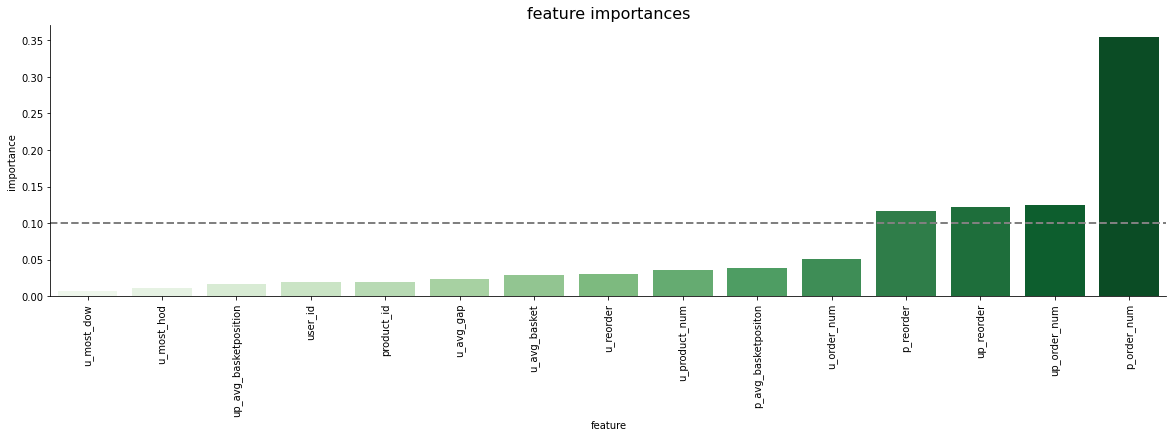

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

imp = model.feature_importances_
features = X.columns

fi = pd.DataFrame({'importance' : imp, 
                  'feature' : features}).sort_values('importance', ascending = True)

plt.figure(figsize = (20, 5))
sns.barplot(y = 'importance', x = 'feature', data = fi, palette = 'Greens')
plt.axhline(y = 0.1, color='gray', linestyle='--', linewidth=2)
plt.title('feature importances', fontdict = {'fontsize' : 16})
plt.xticks(rotation = 90)
plt.gca().spines['right'].set_visible(False) 
plt.gca().spines['top'].set_visible(False)

**결과 해석**  
**모델에 영향을 크게 미치는 4개의 feature는 아래와 같다**  
1. **p_order_num** : 특정 상품이 전체고객들로부터 구매된 횟수 - **약 36%**
2. **up_order_num** : 고객이 특정 상품을 주문한 횟수 - **약 12%**
3. **up_reorder** : 고객이 특정 상품을 재주문했던 확률(0~1사이의 값) - **약 12%**
4. **p_reorder** : 특정 상품이 전체 고객들로부터 재주문됐던 확률(0~1사이의 값) - **약 12%**  
    
이 중 **p_order_num** 과 **p_reorder_num** 은 그 제품 자체가 얼마나 인기가 많고 재주문이 많이 되었는지에 관한 피쳐이고  
**up_order_num** 과 **up_reorder** 는 특정 고객이 해당 제품을 얼마나 주문을 많이했고, 다시 재주문을 했는지에 관한 피쳐이다   
  
**따라서 고객의 주문을 높이려면 방법에는 두가지 방법이 있다고 해석할 수 있다**
1. 가장 인기가 많은 상품을 추천한다.(p_order_num 과 p_reorder_num)  
2. 고객의 이전 장바구니를 파악하여 이미 주문한 제품 또는 관련이 있는 상품을 추천한다(up_order_num 과 up_reorder)  

2와 관련하여 고객의 장바구니에 담겨있는 제품을 파악하여 관련이 있는 제품을 추천하는 장바구니 분석을 사용할 수 있다